In [1]:
from google.cloud import bigquery
from google.oauth2 import service_account
from google.cloud import bigquery
from google.cloud.exceptions import NotFound
import pandas as pd
from utils.utils_bigquery import *
from datetime import *

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.cluster import KMeans
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import Birch
from sklearn.cluster import MeanShift
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import OPTICS

In [3]:
# Define the key path for authentication and the project ID for BigQuery
key_path = key_path  
project = project_id  

# Define the source table and dataset
table = 'gold_main_sp500' 
dataset = 'gold'  
table_conca = f'{project}.{dataset}.{table}'  

# Define the target table and dataset for saving results
table_to_save = 'gold_clustering_sp500'  
dataset_to_save = 'gold'  
table_conca_to_save = f'{project}.{dataset_to_save}.{table_to_save}'  


In [4]:
# Connect to BigQuery using the BigQueryUtils class
bigquery = BigQueryUtils(key_path)

In [5]:
# Run a SQL query to retrieve the historical values for each ticker

df = bigquery.run_query(
    f"""
        SELECT
            ti.date,
            ti.ticker,
            ti.adjclose
        FROM {table_conca} AS ti
        INNER JOIN `bronze.bronze_sp500_tickers` AS sp
            ON sp.ticker = ti.ticker
    """
)
df

,date,ticker,adjclose
0,2018-07-24 00:00:00+00:00,VTRS,36.033947
1,2018-07-24 00:00:00+00:00,GLW,27.003014
2,2018-07-24 00:00:00+00:00,VMC,117.070572
3,2018-07-24 00:00:00+00:00,COST,206.898041
4,2018-07-24 00:00:00+00:00,DVA,70.070000
...,...,...,...
1179574,2024-03-15 00:00:00+00:00,XOM,111.269997
1179575,2024-03-07 00:00:00+00:00,CPB,42.070000
1179576,2024-03-07 00:00:00+00:00,JCI,61.320000
1179577,2024-03-07 00:00:00+00:00,SHW,344.660004


In [6]:
# Convert the 'date' column to datetime format
df['date'] = pd.to_datetime(df['date'])

# Pivot the DataFrame to have dates as the index and tickers as columns
df_pivoted = df.pivot(index='date', columns='ticker', values='adjclose')

# Display the pivoted DataFrame
df_pivoted


ticker,A,AAL,AAPL,ABBV,ABT,ACGL,ACN,ADBE,ADI,ADM,...,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS,date
date,,,,,,,,,,,,,,,,,,,,,
2015-01-02 00:00:00+00:00,38.134743,51.079918,24.819241,47.606876,39.116329,19.496668,77.739143,72.339996,47.992855,42.047760,...,26.735615,129.636993,29.513472,66.025864,34.689079,45.366924,103.273209,77.430000,41.283794,NaT
2015-01-05 00:00:00+00:00,37.420185,51.051483,24.120045,46.710945,39.125034,19.379999,76.426567,71.980003,47.120094,40.592819,...,26.735615,127.430626,29.178459,64.219269,32.530121,44.445164,107.125671,76.339996,41.035954,NaT
2015-01-06 00:00:00+00:00,36.837265,50.255585,24.122320,46.479752,38.680729,19.423332,75.875282,70.529999,46.014027,39.792606,...,26.705992,124.712402,29.333715,63.877869,32.338821,43.899632,106.217575,75.790001,40.635601,NaT
2015-01-07 00:00:00+00:00,37.326168,50.227158,24.460564,48.358299,38.994354,19.536667,77.467850,71.110001,46.497940,40.390751,...,26.787432,128.374954,29.587006,64.525108,32.593887,45.354382,108.859299,77.720001,41.474419,NaT
2015-01-08 00:00:00+00:00,38.445004,50.843037,25.400398,48.864059,39.795853,19.876667,78.649185,72.919998,47.318844,39.800697,...,27.076199,129.919449,29.930189,65.599113,32.839859,46.144466,110.015007,79.379997,42.113091,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-12 00:00:00+00:00,135.600006,9.610000,217.529999,190.179993,107.800003,97.970001,313.959991,530.929993,212.080002,58.070000,...,30.139999,73.930000,58.020000,119.000000,127.500000,135.630005,107.000000,320.339996,183.809998,NaT
2024-08-13 00:00:00+00:00,137.419998,9.810000,221.270004,191.229996,108.239998,97.730003,319.329987,535.219971,218.009995,58.380001,...,30.330000,74.199997,59.660000,117.860001,131.710007,137.589996,109.309998,332.119995,188.380005,NaT
2024-08-14 00:00:00+00:00,136.029999,9.740000,221.720001,193.000000,109.889999,100.900002,319.829987,539.789978,215.320007,58.380001,...,30.020000,74.040001,58.959999,118.949997,131.490005,137.259995,108.629997,333.239990,183.380005,NaT


In [7]:
from tslearn.preprocessing import TimeSeriesScalerMeanVariance

# Filter data from 2021 onwards
close_prices = df_pivoted.loc["2021":]

# Remove columns with NaN values
close_prices = close_prices.dropna(axis=1)

# Transform the data using TimeSeriesScalerMeanVariance (normalize the time series values)
X_train = TimeSeriesScalerMeanVariance().fit_transform(close_prices.T)

# Print the shape of the transformed data
print(X_train.shape)

(493, 910, 1)


In [34]:
import pickle
from tslearn.clustering import TimeSeriesKMeans
from sklearn.metrics import adjusted_mutual_info_score as ami
from tqdm import tqdm
import matplotlib.pyplot as plt

# Define the path to load the pickle file
pickle_loading_lower = 'sp500_clustering.pickle'

# Load the saved results dictionary if it exists
try:
    with open(pickle_loading_lower, 'rb') as handle:
        result_dict = pickle.load(handle)
    print("File successfully loaded.")
    
    # Check that the loaded object is a dictionary
    if not isinstance(result_dict, dict):
        print("Warning: The loaded file is not a dictionary. Resetting result_dict.")
        result_dict = {}
except FileNotFoundError:
    result_dict = {}
    print("File not found, starting from scratch.")

# Define the clustering function
def ad_clustering(X_train, k, seed=123):
    """
    Perform time series clustering using KMeans with Dynamic Time Warping (DTW) distance.

    Parameters:
    - X_train: The input time series data for clustering (shape: [n_samples, n_timestamps, n_features]).
    - k: The number of clusters to form.
    - seed: The random seed for initializing the KMeans algorithm (default is 123).

    Returns:
    - model: The fitted TimeSeriesKMeans model.
    - y_pred: Cluster labels for each time series in X_train.
    - wcss: Within-cluster sum of squares, a measure of clustering quality.
    """
    model = TimeSeriesKMeans(
        n_clusters=k,               # Number of clusters to form
        n_init=2,                   # Number of initializations to perform (for finding the best solution)
        metric="dtw",               # Distance metric: Dynamic Time Warping
        verbose=True,               # Print detailed information about the clustering process
        max_iter_barycenter=10,     # Maximum number of iterations for computing the barycenter (average time series)
        tol=1e-2,                   # Tolerance for convergence (stopping criterion)
        random_state=seed,          # Random seed for reproducibility
        n_jobs=-1                   # Number of parallel jobs to run (use all available CPUs)
    )
    y_pred = model.fit_predict(X_train)   # Perform clustering and predict cluster labels
    wcss = model.inertia_                # Calculate the within-cluster sum of squares (WCSS)
    return model, y_pred, wcss           # Return the model, predicted labels, and WCSS


# Continue from the last k value
starting_k = max(result_dict.keys()) + 1 if result_dict else 3

# Use tqdm to show a progress bar
for k in tqdm(range(starting_k, 10)):
    model, y_pred, wcss = ad_clustering(X_train, k)
    result_dict[k] = (model, y_pred, wcss)
    print(f"For k = {k}, clustering done")

    # Save the results to a pickle file after each iteration
    with open(pickle_loading_lower, 'wb') as handle:
        pickle.dump(result_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)


Archivo cargado exitosamente.


  0%|          | 0/2 [00:00<?, ?it/s]

Init 1


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 493 out of 493 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 1218 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 1768 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 1972 out of 1972 | elapsed:    3.5s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elaps

69.075 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 1218 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 1768 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 2418 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 3168 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 3944 out of 3944 | elapsed:    7.4s finished


32.286 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 1218 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 1768 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 2418 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 3168 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 3944 out of 3944 | elapsed:    8.8s finished


30.993 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 1218 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 1768 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 2418 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 3168 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 3944 out of 3944 | elapsed:    6.6s finished


30.780 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 1218 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 1768 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 2418 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 3168 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 3944 out of 3944 | elapsed:    7.2s finished


30.663 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 1218 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 1768 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 2418 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 3168 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 3944 out of 3944 | elapsed:    6.9s finished


30.614 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 1218 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 1768 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 2418 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 3168 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 3944 out of 3944 | elapsed:    7.9s finished


30.614 --> 
Init 2


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 493 out of 493 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 1218 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 1768 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 1972 out of 1972 | elapsed:    2.9s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elaps

71.639 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 1218 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 1768 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 2418 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 3168 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 3944 out of 3944 | elapsed:    6.9s finished


32.154 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 1218 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 1768 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 2418 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 3168 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 3944 out of 3944 | elapsed:    6.7s finished


31.027 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 1218 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 1768 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 2418 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 3168 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 3944 out of 3944 | elapsed:    7.7s finished


30.838 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 1218 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 1768 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 2418 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 3168 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 3944 out of 3944 | elapsed:    8.0s finished


30.787 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 1218 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 1768 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 2418 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 3168 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 3944 out of 3944 | elapsed:    6.6s finished


30.787 --> 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 1218 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 1768 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 2418 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 3168 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 3944 out of 3944 | elapsed:    6.5s finished
 50%|█████     | 1/2 [25:47<25:47, 1547.43s/it][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s


For k = 8, clustering done
Init 1


[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 493 out of 493 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 1218 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 1768 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 1972 out of 1972 | elapsed:    3.4s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:    0.7s
[Paralle

67.414 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 1218 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 1768 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 2418 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 3168 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 4018 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 4437 out of 4437 | elapsed:    7.2s finished


31.291 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 1218 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 1768 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 2418 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 3168 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 4018 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 4437 out of 4437 | elapsed:    7.8s finished


30.352 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 1218 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 1768 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 2418 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 3168 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 4018 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 4437 out of 4437 | elapsed:    8.5s finished


30.238 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 1218 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 1768 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 2418 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 3168 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 4018 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 4437 out of 4437 | elapsed:    7.6s finished


30.171 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 1218 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 1768 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 2418 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 3168 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 4018 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 4437 out of 4437 | elapsed:    8.2s finished


30.144 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 1218 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 1768 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 2418 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 3168 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 4018 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 4437 out of 4437 | elapsed:    8.4s finished


30.144 --> 
Init 2


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 493 out of 493 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 1218 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 1768 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 1972 out of 1972 | elapsed:    3.6s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elaps

65.596 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 1218 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 1768 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 2418 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 3168 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 4018 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 4437 out of 4437 | elapsed:    8.1s finished


30.664 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 1218 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 1768 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 2418 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 3168 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 4018 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 4437 out of 4437 | elapsed:    7.6s finished


29.999 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 1218 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 1768 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 2418 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 3168 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 4018 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 4437 out of 4437 | elapsed:    8.5s finished


29.786 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 1218 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 1768 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 2418 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 3168 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 4018 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 4437 out of 4437 | elapsed:    8.2s finished


29.602 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 1218 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 1768 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 2418 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 3168 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 4018 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 4437 out of 4437 | elapsed:    8.3s finished


29.571 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 1218 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 1768 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 2418 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 3168 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 4018 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 4437 out of 4437 | elapsed:    8.5s finished


29.554 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 1218 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 1768 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 2418 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 3168 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 4018 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 4437 out of 4437 | elapsed:    7.6s finished


29.554 --> 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 1218 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 1768 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 2418 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 3168 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 4018 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 4437 out of 4437 | elapsed:    7.5s finished
100%|██████████| 2/2 [49:36<00:00, 1488.39s/it]

For k = 9, clustering done


In [29]:
# import pickle
# 
# # Cargar el primer archivo pickle
# with open('lower_result_dict_partial.pickle', 'rb') as f:
#     dict1 = pickle.load(f)
# 
# # Cargar el segundo archivo pickle
# with open('result_dict_partial.pickle', 'rb') as f:
#     dict2 = pickle.load(f)
# 
# # Verificar el tipo de datos cargados
# print(f"Tipo de dict1: {type(dict1)}")
# print(f"Tipo de dict2: {type(dict2)}")
# 
# # Unir los diccionarios si ambos son del tipo dict
# if isinstance(dict1, dict) and isinstance(dict2, dict):
#     combined_dict = dict1.copy()  # Copiar el primer diccionario
#     combined_dict.update(dict2)   # Actualizarlo con los valores del segundo diccionario
#     
#     # Guardar el diccionario combinado en un nuevo archivo pickle
#     with open('sp500_clustering.pickle', 'wb') as f:
#         pickle.dump(combined_dict, f, protocol=pickle.HIGHEST_PROTOCOL)
# else:
#     print("Uno o ambos archivos pickle no contienen diccionarios.")


Tipo de dict1: <class 'dict'>
Tipo de dict2: <class 'dict'>


In [32]:
# with open('sp500_clustering.pickle', 'rb') as f:
#     combined = pickle.load(f)

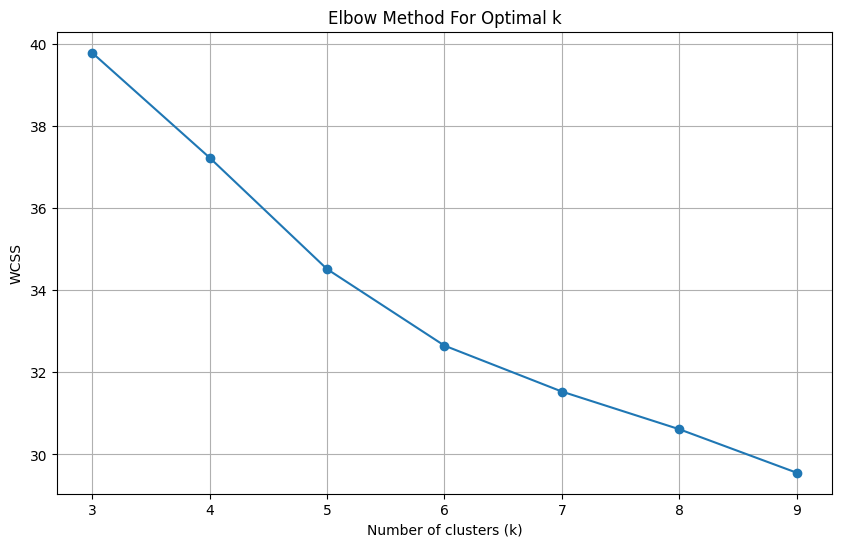

In [35]:
import matplotlib.pyplot as plt

# Extract WCSS values from the results dictionary
# WCSS: Within-cluster sum of squares, a measure of cluster compactness
wcss_values = [result_dict[k][2] for k in sorted(result_dict.keys())]

# Plot the elbow method graph
plt.figure(figsize=(10, 6)) 
plt.plot(sorted(result_dict.keys()), wcss_values, marker='o') 
plt.title('Elbow Method For Optimal k')  
plt.xlabel('Number of clusters (k)')  
plt.ylabel('WCSS')  
plt.grid(True)  
plt.show()  


In [38]:
# Now we will use the trained model on the entire DataFrame
# Assume the optimal number of clusters has been determined to be 8
optimal_k = 6

# Extract the optimal model for the determined number of clusters
model, _, _ = result_dict[optimal_k]

# Transform the entire original DataFrame for prediction
# Remove columns with NaN values
close_prices = close_prices.dropna(axis=1)

# Filter data from 2021 onwards
close_prices_all = close_prices.loc["2021":]

# Scale and transform the data using TimeSeriesScalerMeanVariance
X_all = TimeSeriesScalerMeanVariance().fit_transform(close_prices_all.T)

# Predict clusters using the optimal model
y_pred_all = model.predict(X_all)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 1218 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 1768 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 2418 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 2958 out of 2958 | elapsed:    4.5s finished


In [39]:
# Map clustering results to tickers
# Create a dictionary mapping tickers to their assigned clusters
tickers_in_clustering = close_prices_all.columns
ticker_to_cluster = {ticker: cluster for ticker, cluster in zip(tickers_in_clustering, y_pred_all)}

# Get unique tickers from the original DataFrame
unique_tickers = df['ticker'].unique()

# Create a DataFrame with unique tickers and their assigned clusters
unique_tickers_df = pd.DataFrame({
    'ticker': unique_tickers
})
unique_tickers_df['cluster'] = unique_tickers_df['ticker'].map(ticker_to_cluster)

unique_tickers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 493 entries, 0 to 492
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   ticker   493 non-null    object
 1   cluster  493 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 7.8+ KB


In [40]:
# Save the DataFrame to BigQuery
bigquery.save_dataframe(unique_tickers_df, project, dataset_to_save, table_to_save, if_exists='replace', schema=None)

100%|██████████| 1/1 [00:00<?, ?it/s]
